In [0]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import nltk
import re
from scipy.spatial.distance import cdist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
#/////////////////////////////////////
#// Use this on Google Colaboratory
#////////////////////////////////////

# from google.colab import drive
# drive.mount('/content/gdrive')
# df = pd.read_csv("gdrive/My Drive/CZ4034 Info Retrieval/wilson_sentiments.csv", delimiter=",", header=0)



#////////////////////////////////
#// Use this on local machines
#///////////////////////////////

df = pd.read_csv("./wilson_sentiments.csv", delimiter=",", header=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Take only the csv entries with sentiments labelled
df = df.head(1061)

In [0]:
df = df[["id", "sentiments", "quote"]]

In [0]:
df

,id,sentiments,quote
0,0,0.0,"I'm selfish, impatient and a little insecure. ..."
1,1,1.0,Be yourself; everyone else is already taken.
2,2,0.0,Two things are infinite: the universe and huma...
3,3,0.0,"So many books, so little time."
4,4,0.0,"Be who you are and say what you feel, because ..."
...,...,...,...
1056,1056,1.0,"Remember that wherever your heart is, there yo..."
1057,1057,1.0,History will be kind to me for I intend to wri...
1058,1058,1.0,Respect other people's feelings. It might mean...
1059,1059,1.0,"Take responsibility of your own happiness, nev..."


In [0]:
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
nltk.download('wordnet')

processed_quotes = []

for sen in df["quote"]:
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sen))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    processed_quotes.append(document)
    
df["processed_quotes"] = processed_quotes
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,sentiments,quote,processed_quotes
0,0,0.0,"I'm selfish, impatient and a little insecure. ...",i selfish impatient and little insecure make m...
1,1,1.0,Be yourself; everyone else is already taken.,be yourself everyone else is already taken
2,2,0.0,Two things are infinite: the universe and huma...,two thing are infinite the universe and human ...
3,3,0.0,"So many books, so little time.",so many book so little time
4,4,0.0,"Be who you are and say what you feel, because ...",be who you are and say what you feel because t...
...,...,...,...,...
1056,1056,1.0,"Remember that wherever your heart is, there yo...",remember that wherever your heart is there you...
1057,1057,1.0,History will be kind to me for I intend to wri...,history will be kind to me for intend to write it
1058,1058,1.0,Respect other people's feelings. It might mean...,respect other people feeling it might mean not...
1059,1059,1.0,"Take responsibility of your own happiness, nev...",take responsibility of your own happiness neve...


In [0]:
# print(df.iloc[:,3])  # take the processed quotes
# print(df.iloc[:,1])  # take only the sentiments

# x is the quotes, y is the sentiment values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,3], df.iloc[:,1], test_size=0.20, random_state=42)

# Check to see if x_train + x_test gives back 1061 entries
text = pd.concat([x_train,x_test])
print(text)

72     if you can explain it to six year old you don ...
898    true love is rare and it the only thing that g...
44     yesterday is history tomorrow is mystery today...
309             i would die for you but won live for you
784    it strange because sometimes read book and thi...
                             ...                        
581         think before you speak read before you think
55     i am enough of an artist to draw freely upon m...
120    it matter not what someone is born but what th...
388    nobody ha ever measured not even poet how much...
25     insanity is doing the same thing over and over...
Name: processed_quotes, Length: 1061, dtype: object


In [0]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
# print(tokenizer)
tokenizer.fit_on_texts(text)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
print("Mean length is " + str(np.mean(num_tokens)))

Mean length is 23.158341187558907


In [0]:
#Chose to 2 S.D to cover ~95% of data
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

77


In [0]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding='pre', truncating='pre')

In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [0]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = " ".join(words)
    return text

In [0]:
model = Sequential()
embedding_size = 100

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(GRU(units=16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(units=16, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(GRU(units=8, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(GRU(units=4, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 77, 100)           1000000   
_________________________________________________________________
gru (GRU)                    (None, 77, 16)            5664      
_________________________________________________________________
gru_1 (GRU)                  (None, 77, 16)            1632      
_________________________________________________________________
gru_2 (GRU)                  (None, 77, 8)             624       
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [0]:
history = model.fit(x_train_pad, 
                    y_train,
                    validation_split=0.05, 
                    epochs=20, 
                    batch_size=32)

Epoch 1/20
26/26 [==============================] - 25s 948ms/step - loss: 0.6933 - accuracy: 0.5528 - val_loss: 0.6847 - val_accuracy: 0.6512
Epoch 2/20
26/26 [==============================] - 24s 922ms/step - loss: 0.6888 - accuracy: 0.5565 - val_loss: 0.6825 - val_accuracy: 0.6512
Epoch 3/20
26/26 [==============================] - 23s 898ms/step - loss: 0.6823 - accuracy: 0.5553 - val_loss: 0.6768 - val_accuracy: 0.6512
Epoch 4/20
26/26 [==============================] - 23s 896ms/step - loss: 0.6275 - accuracy: 0.6273 - val_loss: 0.6456 - val_accuracy: 0.6512
Epoch 5/20
26/26 [==============================] - 24s 911ms/step - loss: 0.4834 - accuracy: 0.8385 - val_loss: 0.6656 - val_accuracy: 0.5814
Epoch 6/20
26/26 [==============================] - 23s 891ms/step - loss: 0.3208 - accuracy: 0.8944 - val_loss: 0.8053 - val_accuracy: 0.6512
Epoch 7/20
26/26 [==============================] - 23s 888ms/step - loss: 0.2118 - accuracy: 0.9354 - val_loss: 1.0117 - val_accuracy: 0.5349

In [0]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)

7/7 [==============================] - 0s 61ms/step - loss: 1.8387 - accuracy: 0.6338


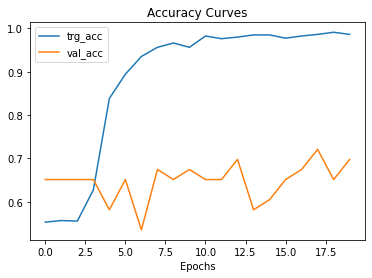

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Curves")
plt.legend(["trg_acc", "val_acc"])
plt.xlabel("Epochs")
plt.show()

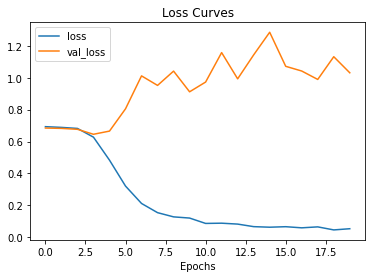

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curves")
plt.legend(["loss", "val_loss"])
plt.xlabel("Epochs")
plt.show()

In [0]:
predictions_gru = model.predict_classes(x_test_pad)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
print(predictions_gru)

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]


In [0]:
predictions_gru.shape

(213, 1)

In [0]:
from sklearn.metrics import f1_score
gru_f1 = f1_score(y_test, predictions_gru, average='macro')
print("F1 Score for GRU is:", gru_f1)

F1 Score for GRU is: 0.6278225806451614


# Symbolic AI

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
 
 
vader = SentimentIntensityAnalyzer()
def vader_polarity(text):
    """ Transform the output to a binary 0/1 result """
    score = vader.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

predictions_vader = [vader_polarity(text) for text in x_test]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
predictions_vader = np.array(predictions_vader).reshape(-1,1)

In [0]:
# print(predictions_vader)
vader_f1 = f1_score(y_test, predictions_vader, average='macro')

print("F1 Score for Symbolic AI method is:", vader_f1)

F1 Score for Symbolic AI method is: 0.6525745018515254


# Bert

In [0]:
!pip3 install ktrain

import ktrain
from ktrain import text

     |████████████████████████████████| 25.2MB 129kB/s 
     |████████████████████████████████| 421.8MB 44kB/s 
     |████████████████████████████████| 983kB 50.3MB/s 
     |████████████████████████████████| 245kB 61.1MB/s 
     |████████████████████████████████| 573kB 47.4MB/s 
     |████████████████████████████████| 471kB 59.1MB/s 
     |████████████████████████████████| 3.9MB 44.9MB/s 
     |████████████████████████████████| 450kB 59.3MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
     |████████████████████████████████| 3.7MB 44.4MB/s 
     |████████████████████████████████| 1.0MB 47.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.14.2-cp36-none-any.whl size=25245177 sha256=d9c28752d10e51ef6fafc1af9ff8c1dbc37e0c795f7b040d8fc969a52070bfd7
  Stored in directory: /root/.cache/pip/wheels/d2/52/11/747feea8ec83ff98a49d81dd1115a67ceb7b4a4ed0f8a37efe
  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=df88a4f029f0705d0d5573175ce

In [0]:
train_bert = pd.concat([x_train, y_train], axis=1, names=['preprocessed_quotes', 'sentiments'])

In [0]:
train_bert.shape

(848, 2)

In [0]:
(x_train_bert, y_train_bert, preproc) = text.texts_from_df(train_bert, 
                   text_column='processed_quotes', \
                   label_columns = 'sentiments', \
                   random_state=0, \
                    maxlen=500, \
                    preprocess_mode='bert') \

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
y_train_bert

([array([[ 101, 1045, 2064, ...,    0,    0,    0],
         [ 101, 1045, 2442, ...,    0,    0,    0],
         [ 101, 2079, 2028, ...,    0,    0,    0],
         ...,
         [ 101, 2682, 2035, ...,    0,    0,    0],
         [ 101, 2022, 2785, ...,    0,    0,    0],
         [ 101, 2017, 2156, ...,    0,    0,    0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])],
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
 

In [0]:
test_bert = pd.concat([x_test, y_test], axis=1, names=['preprocessed_quotes', 'sentiments'])

In [0]:
test_bert

,processed_quotes,sentiments
31,it is our choice harry that show what we truly...,1.0
413,we fell in love despite our difference and onc...,1.0
535,the mind is it own place and in itself can mak...,0.0
743,no book is really worth reading at the age of ...,0.0
792,i wa never really insane except upon occasion ...,1.0
...,...,...
581,think before you speak read before you think,1.0
55,i am enough of an artist to draw freely upon m...,1.0
120,it matter not what someone is born but what th...,1.0
388,nobody ha ever measured not even poet how much...,0.0


In [0]:
(x_test_bert, y_test_bert, preproc_test) = text.texts_from_df(test_bert, 
                   text_column='processed_quotes', \
                   label_columns = ['sentiments'], \
                   random_state=0, \
                    maxlen=500, \
                    preprocess_mode='bert') \

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
type(x_train)

pandas.core.series.Series

In [0]:
(x_train_bert,  y_train_bert), (x_test_bert, y_test_bert), preproc = text.texts_from_array(x_train=x_train.tolist(), y_train=y_train.tolist(),
                                                                       x_test=x_test.tolist(), y_test=y_test.tolist(),
                                                                       class_names=[0., 1.],
                                                                       preprocess_mode='bert',
                                                                       maxlen=350)

task: text classification
preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
model_bert = text.text_classifier('bert', train_data=(x_train_bert,y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model_bert,train_data=(x_train_bert,y_train_bert), val_data=(x_test_bert, y_test_bert), batch_size=6)

Is Multi-Label? False
maxlen is 350
done.


In [0]:
bert_epoch = 1
for i in range (bert_epoch):
  learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
142/142 [==============================] - 77s 540ms/step - loss: 0.6894 - accuracy: 0.5719 - val_loss: 0.6473 - val_accuracy: 0.6901


In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [0]:
predictions_bert = predictor.predict(x_test.tolist())

In [0]:
predictions_bert = list(map(int, predictions_bert))
len(predictions_bert)

213

In [0]:
bert_f1 = f1_score(y_test, predictions_bert, average='macro')

print("F1 Score for BERT:", bert_f1)

F1 Score for BERT: 0.6850806451612903


# Ensemble RFC

In [0]:
df_ensemble = pd.DataFrame(predictions_gru, columns=["predictions_gru"])
df_ensemble['predictions_vader'] = predictions_vader
df_ensemble['predictions_bert'] = predictions_bert

In [0]:
df_ensemble

,predictions_gru,predictions_vader,predictions_bert
0,0,1,1
1,0,1,1
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
208,1,0,1
209,1,1,1
210,1,1,1
211,0,1,0


In [0]:
y_test = list(map(int, y_test))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf = clf.fit(df_ensemble, y_test)

In [0]:
clf.score(df_ensemble, y_test)

0.7276995305164319